In [1]:
import os
from torch import nn
import random
from torchvision import transforms
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, RandomRotate90,
    Transpose, ShiftScaleRotate, HueSaturationValue, RandomResizedCrop, RandomBrightnessContrast, Compose, Normalize, Cutout, CoarseDropout, CenterCrop
)
import cv2
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
import timm
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.nn import functional as F
from fmix.fmix import sample_mask

C:\Users\79826\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
def get_img(dir_, file):
    img = cv2.imread(os.path.join(dir_, file))
    img = img[:, :, ::-1]
    return img

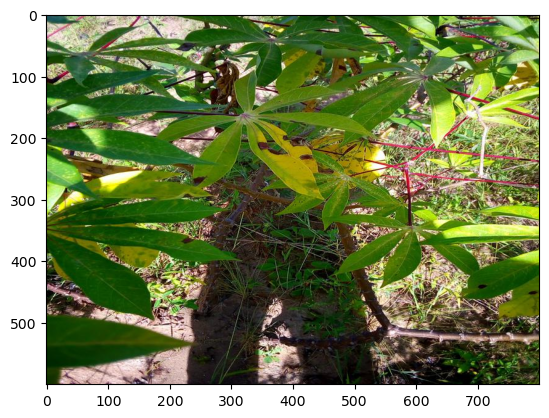

In [4]:
img = get_img('train_images', os.listdir('train_images')[0])
plt.imshow(img)

In [5]:
train = pd.read_csv('train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
train_dir = 'train_images'

In [7]:
def bbox(size, lam):
    w = size[0]
    h = size[1]
    rat = np.sqrt(1. - lam)
    cut_w = np.int(w * rat)
    cut_h = np.int(h * rat)
    cx = np.random.randint(w)
    cy = np.random.randint(h)
    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)
    return bbx1, bby1, bbx2, bby2

In [8]:
class CassavaDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, dir_, transforms=None):
        super().__init__()
        self.df = df
        self.dir = dir_
        self.transforms = transforms
    
    def __getitem__(self, ind):
        img = get_img(self.dir, self.df.iloc[ind]['image_id'])
        if self.transforms:
            img = self.transforms(image=img)['image']
        target = self.df.iloc[ind]['label']
        return img, target
    
    def __len__(self):
        return self.df.shape[0]

In [9]:
def cutmix(x, y, alpha, shape):
    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    inds = torch.randperm(x.shape[0])
    x_shuffle = x[inds]
    y_shuffle = y[inds]
    bbx1, bby1, bbx2, bby2 = bbox(shape, lam)
    x[:, bbx1:bbx2, bby1:bby2] = x_shuffle[:, bbx1:bbx2, bby1:bby2]
    rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (shape[0] * shape[1]))
    return x, y, y_shuffle, rate
    

In [10]:
def fmix(data, targets, alpha, decay_power, shape, device, max_soft=0.0):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1-mask).to(device) * shuffled_data   
    return (x1+x2), targets, shuffled_targets, lam

In [11]:
augs = {'soft': Compose([
            RandomResizedCrop(512, 512),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),

            ToTensorV2(p=1.0),
        ], p=1.),
       'hard': Compose([
            RandomResizedCrop(512, 512),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.),}

In [12]:
def valid_transforms():
    return Compose([
            CenterCrop(512, 512),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

In [13]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
def prepare_dataloader(df, trn_idx, val_idx, augs_, data_root=train_dir):
    
    train_ = df.iloc[trn_idx]
    valid_ = df.iloc[val_idx]     
    train_ds = CassavaDataset(train_, data_root, transforms=augs_)
    valid_ds = CassavaDataset(valid_, data_root, transforms=valid_transforms())
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=4,
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=0
)
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=16,
        num_workers=0,
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [15]:
def train_one_epoch(epoch, model, loss, optimizer, loader, device, mix, accum_iter, scaler, fold, scheduler=None):
    model.train()
    pbar = tqdm(enumerate(loader), total=len(loader))
    running_loss = None
    all_ = 0
    correct = 0
    size = 512
    for i, (x, y) in pbar:
        x = x.to(device).float()
        y = y.to(device).long()
        rand = np.random.uniform(0, 1, size=1)[0]
        if mix == 'cutmix' and rand > 0.5:
            x, y, y_shuffle, rate = cutmix(x, y, 1., (size, size))
        elif mix == 'fmix' and rand > 0.5:
            x, y, y_shuffle, rate = fmix(x, y, 1, 5, (size, size), device)
        elif mix == 'fmix_cutmix':
            if rand > 0.75:
                x, y, y_shuffle, rate = cutmix(x, y, 1., (size, size))
            elif rand > 0.5:
                x, y, y_shuffle, rate = fmix(x, y, 1, 5, (size, size), device)
        with autocast():
            out = model(x.float())
            if rand > 0.5 and mix:
                loss_ = loss(out, y) * rate + loss(out, y_shuffle) * (1 - rate)
            else:
                loss_ = loss(out, y)
        scaler.scale(loss_ / accum_iter).backward()
        preds = torch.argmax(out, -1)
        correct += (preds == y).sum()
        all_ += y.shape[0]
        if (i + 1) % accum_iter == 0:
            
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
#         optimizer.step()
        if running_loss:
            running_loss = running_loss * .99 + loss_.item() * .01
        else:
            running_loss = loss_.item()
        if ((i + 1) % 2 == 0) or ((i + 1) == len(loader)):
                description = f'fold {fold} epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
                if scheduler is not None:
                    scheduler.step()
    print('train accuracy = {:.4f}'.format(correct / all_))
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, fold):
    model.eval()

    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for i, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item() * image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((i + 1) % 2 == 0) or ((i + 1) == len(val_loader)):
            description = f'fold {fold} epoch {epoch} loss: {loss_sum / sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    acc = (image_preds_all==image_targets_all).mean()
    print('validation multi-class accuracy = {:.4f}'.format(acc))
    return acc
    

In [16]:
def train_loop(model_name, scheduler_, mix, accum_iter, lr, num_epochs, augs_type, t):
    seed_everything(11)
    folds = StratifiedKFold(5, shuffle=True, random_state=11).split(np.arange(train.shape[0]), train.label.values)
    model_weights_dir = '{}_{}_{}_{}_{}_{}'.format(model_name, mix, scheduler_, accum_iter, augs_type, lr)
    os.mkdir(model_weights_dir)
    for i in range(num_epochs):
        path_ = os.path.join(model_weights_dir, str(i))
        os.mkdir(path_)
        for j in range(5):
            path = os.path.join(path_, str(j))
            os.mkdir(path)
    for fold, (trn_idx, val_idx) in enumerate(folds):
        augs_ = augs[augs_type]
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, augs_, data_root=train_dir)

        device = torch.device('cuda:0')

        model = CassvaImgClassifier(model_name, train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        if scheduler_ == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=t, T_mult=1, eta_min=1e-6, last_epoch=-1)
        else:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=0, verbose=True, min_lr=1e-6)
        loss_tr = nn.CrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        best_acc = 0
        for epoch in range(num_epochs):
            if scheduler_ == 'cosine':
                train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, mix, accum_iter, scaler, fold)
                scheduler.step()
            else:
                train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, mix, accum_iter, scaler, fold)
            with torch.no_grad():
                acc = valid_one_epoch(epoch, model, loss_fn, val_loader, device, fold)
                if scheduler_ != 'cosine':
                    scheduler.step(acc)
            torch.save(model.state_dict(), os.path.join(model_weights_dir, str(epoch), str(fold), '{}_{}'.format(round(acc, 4), epoch)))
        del model, optimizer, train_loader, val_loader, scaler
        torch.cuda.empty_cache()

In [21]:
train_loop('tf_efficientnet_b4_ns', 'cosine', 'fmix_cutmix', 8, 3e-4, 15, 'hard', 10)

fold 1 epoch 0 loss: 0.7694: 100%|██████████| 4280/4280 [20:34<00:00,  3.47it/s]


train accuracy = 0.7258


fold 1 epoch 0 loss: 0.5123: 100%|██████████| 268/268 [02:26<00:00,  1.82it/s]


validation multi-class accuracy = 0.8376


fold 1 epoch 1 loss: 0.6777: 100%|██████████| 4280/4280 [20:30<00:00,  3.48it/s]


train accuracy = 0.7757


fold 1 epoch 1 loss: 0.4221: 100%|██████████| 268/268 [02:25<00:00,  1.84it/s]


validation multi-class accuracy = 0.8699


fold 1 epoch 2 loss: 0.5856: 100%|██████████| 4280/4280 [20:36<00:00,  3.46it/s]


train accuracy = 0.7905


fold 1 epoch 2 loss: 0.4019: 100%|██████████| 268/268 [02:23<00:00,  1.87it/s]


validation multi-class accuracy = 0.8699


fold 1 epoch 3 loss: 0.6410: 100%|██████████| 4280/4280 [20:45<00:00,  3.44it/s]


train accuracy = 0.7973


fold 1 epoch 3 loss: 0.4033: 100%|██████████| 268/268 [02:24<00:00,  1.85it/s]


validation multi-class accuracy = 0.8731


fold 1 epoch 4 loss: 0.5557: 100%|██████████| 4280/4280 [20:47<00:00,  3.43it/s]


train accuracy = 0.8051


fold 1 epoch 4 loss: 0.3733: 100%|██████████| 268/268 [02:33<00:00,  1.75it/s]


validation multi-class accuracy = 0.8808


fold 1 epoch 5 loss: 0.5410: 100%|██████████| 4280/4280 [21:21<00:00,  3.34it/s]


train accuracy = 0.8120


fold 1 epoch 5 loss: 0.3728: 100%|██████████| 268/268 [02:24<00:00,  1.85it/s]


validation multi-class accuracy = 0.8762


fold 1 epoch 6 loss: 0.5185: 100%|██████████| 4280/4280 [21:02<00:00,  3.39it/s]


train accuracy = 0.8201


fold 1 epoch 6 loss: 0.4033: 100%|██████████| 268/268 [02:41<00:00,  1.66it/s]


validation multi-class accuracy = 0.8752


fold 1 epoch 7 loss: 0.5415: 100%|██████████| 4280/4280 [22:51<00:00,  3.12it/s]


train accuracy = 0.8229


fold 1 epoch 7 loss: 0.3697: 100%|██████████| 268/268 [02:38<00:00,  1.70it/s]


validation multi-class accuracy = 0.8864


fold 1 epoch 8 loss: 0.5996: 100%|██████████| 4280/4280 [23:15<00:00,  3.07it/s]


train accuracy = 0.8259


fold 1 epoch 8 loss: 0.3598: 100%|██████████| 268/268 [02:45<00:00,  1.62it/s]


validation multi-class accuracy = 0.8879


fold 1 epoch 9 loss: 0.4886: 100%|██████████| 4280/4280 [23:07<00:00,  3.08it/s]


train accuracy = 0.8336


fold 1 epoch 9 loss: 0.3559: 100%|██████████| 268/268 [02:36<00:00,  1.72it/s]


validation multi-class accuracy = 0.8876


fold 1 epoch 10 loss: 0.6441: 100%|██████████| 4280/4280 [22:49<00:00,  3.12it/s]


train accuracy = 0.8125


fold 1 epoch 10 loss: 0.4162: 100%|██████████| 268/268 [02:33<00:00,  1.74it/s]


validation multi-class accuracy = 0.8773


fold 1 epoch 11 loss: 0.6049: 100%|██████████| 4280/4280 [21:29<00:00,  3.32it/s]


train accuracy = 0.8114


fold 1 epoch 11 loss: 0.3780: 100%|██████████| 268/268 [02:26<00:00,  1.82it/s]


validation multi-class accuracy = 0.8799


fold 1 epoch 12 loss: 0.5501: 100%|██████████| 4280/4280 [22:24<00:00,  3.18it/s]


train accuracy = 0.8102


fold 1 epoch 12 loss: 0.4049: 100%|██████████| 268/268 [02:40<00:00,  1.67it/s]


validation multi-class accuracy = 0.8713


fold 1 epoch 13 loss: 0.5097: 100%|██████████| 4280/4280 [23:06<00:00,  3.09it/s]


train accuracy = 0.8167


fold 1 epoch 13 loss: 0.3547: 100%|██████████| 268/268 [02:39<00:00,  1.68it/s]


validation multi-class accuracy = 0.8778


fold 1 epoch 14 loss: 0.5304: 100%|██████████| 4280/4280 [22:25<00:00,  3.18it/s]


train accuracy = 0.8215


fold 1 epoch 14 loss: 0.3888: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8727


fold 2 epoch 0 loss: 0.7885: 100%|██████████| 4280/4280 [20:45<00:00,  3.44it/s]


train accuracy = 0.7216


fold 2 epoch 0 loss: 0.4458: 100%|██████████| 268/268 [02:29<00:00,  1.79it/s]


validation multi-class accuracy = 0.8626


fold 2 epoch 1 loss: 0.6214: 100%|██████████| 4280/4280 [20:28<00:00,  3.48it/s]


train accuracy = 0.7757


fold 2 epoch 1 loss: 0.4468: 100%|██████████| 268/268 [02:25<00:00,  1.84it/s]


validation multi-class accuracy = 0.8696


fold 2 epoch 2 loss: 0.6215: 100%|██████████| 4280/4280 [20:57<00:00,  3.40it/s]


train accuracy = 0.7891


fold 2 epoch 2 loss: 0.3734: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8867


fold 2 epoch 3 loss: 0.5632: 100%|██████████| 4280/4280 [21:04<00:00,  3.38it/s]


train accuracy = 0.7928


fold 2 epoch 3 loss: 0.3500: 100%|██████████| 268/268 [02:28<00:00,  1.81it/s]


validation multi-class accuracy = 0.8899


fold 2 epoch 4 loss: 0.5618: 100%|██████████| 4280/4280 [21:02<00:00,  3.39it/s]


train accuracy = 0.8044


fold 2 epoch 4 loss: 0.3548: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8939


fold 2 epoch 5 loss: 0.5973: 100%|██████████| 4280/4280 [21:02<00:00,  3.39it/s]


train accuracy = 0.8075


fold 2 epoch 5 loss: 0.3678: 100%|██████████| 268/268 [02:29<00:00,  1.79it/s]


validation multi-class accuracy = 0.8895


fold 2 epoch 6 loss: 0.5338: 100%|██████████| 4280/4280 [21:00<00:00,  3.40it/s]


train accuracy = 0.8235


fold 2 epoch 6 loss: 0.3568: 100%|██████████| 268/268 [02:29<00:00,  1.79it/s]


validation multi-class accuracy = 0.8843


fold 2 epoch 7 loss: 0.5383: 100%|██████████| 4280/4280 [21:00<00:00,  3.39it/s]


train accuracy = 0.8228


fold 2 epoch 7 loss: 0.3589: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8892


fold 2 epoch 8 loss: 0.5149: 100%|██████████| 4280/4280 [21:02<00:00,  3.39it/s]


train accuracy = 0.8252


fold 2 epoch 8 loss: 0.3680: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


validation multi-class accuracy = 0.8911


fold 2 epoch 9 loss: 0.4722: 100%|██████████| 4280/4280 [21:01<00:00,  3.39it/s]


train accuracy = 0.8264


fold 2 epoch 9 loss: 0.3512: 100%|██████████| 268/268 [02:34<00:00,  1.73it/s]


validation multi-class accuracy = 0.8937


fold 2 epoch 10 loss: 0.6017: 100%|██████████| 4280/4280 [21:13<00:00,  3.36it/s]


train accuracy = 0.8079


fold 2 epoch 10 loss: 0.4257: 100%|██████████| 268/268 [02:26<00:00,  1.83it/s]


validation multi-class accuracy = 0.8766


fold 2 epoch 11 loss: 0.5700: 100%|██████████| 4280/4280 [21:07<00:00,  3.38it/s]


train accuracy = 0.8054


fold 2 epoch 11 loss: 0.4123: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


validation multi-class accuracy = 0.8799


fold 2 epoch 12 loss: 0.5158: 100%|██████████| 4280/4280 [21:02<00:00,  3.39it/s]


train accuracy = 0.8094


fold 2 epoch 12 loss: 0.3617: 100%|██████████| 268/268 [02:29<00:00,  1.79it/s]


validation multi-class accuracy = 0.8881


fold 2 epoch 13 loss: 0.5923: 100%|██████████| 4280/4280 [21:07<00:00,  3.38it/s]


train accuracy = 0.8162


fold 2 epoch 13 loss: 0.3749: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8839


fold 2 epoch 14 loss: 0.4868: 100%|██████████| 4280/4280 [21:04<00:00,  3.38it/s]


train accuracy = 0.8216


fold 2 epoch 14 loss: 0.3866: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8829


fold 3 epoch 0 loss: 0.7023: 100%|██████████| 4280/4280 [21:18<00:00,  3.35it/s]


train accuracy = 0.7253


fold 3 epoch 0 loss: 0.4160: 100%|██████████| 268/268 [02:37<00:00,  1.70it/s]


validation multi-class accuracy = 0.8701


fold 3 epoch 1 loss: 0.6521: 100%|██████████| 4280/4280 [20:39<00:00,  3.45it/s]


train accuracy = 0.7718


fold 3 epoch 1 loss: 0.4021: 100%|██████████| 268/268 [02:29<00:00,  1.79it/s]


validation multi-class accuracy = 0.8775


fold 3 epoch 2 loss: 0.6251: 100%|██████████| 4280/4280 [20:35<00:00,  3.46it/s]


train accuracy = 0.7932


fold 3 epoch 2 loss: 0.3978: 100%|██████████| 268/268 [02:29<00:00,  1.79it/s]


validation multi-class accuracy = 0.8724


fold 3 epoch 3 loss: 0.6389: 100%|██████████| 4280/4280 [20:36<00:00,  3.46it/s]


train accuracy = 0.7999


fold 3 epoch 3 loss: 0.3952: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


validation multi-class accuracy = 0.8785


fold 3 epoch 4 loss: 0.6022: 100%|██████████| 4280/4280 [20:36<00:00,  3.46it/s]


train accuracy = 0.8127


fold 3 epoch 4 loss: 0.4081: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


validation multi-class accuracy = 0.8801


fold 3 epoch 5 loss: 0.5659: 100%|██████████| 4280/4280 [20:37<00:00,  3.46it/s]


train accuracy = 0.8158


fold 3 epoch 5 loss: 0.3902: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8827


fold 3 epoch 6 loss: 0.5608: 100%|██████████| 4280/4280 [20:34<00:00,  3.47it/s]


train accuracy = 0.8169


fold 3 epoch 6 loss: 0.3724: 100%|██████████| 268/268 [02:25<00:00,  1.84it/s]


validation multi-class accuracy = 0.8815


fold 3 epoch 7 loss: 0.5331: 100%|██████████| 4280/4280 [20:36<00:00,  3.46it/s]


train accuracy = 0.8192


fold 3 epoch 7 loss: 0.3807: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


validation multi-class accuracy = 0.8829


fold 3 epoch 8 loss: 0.5455: 100%|██████████| 4280/4280 [20:33<00:00,  3.47it/s]


train accuracy = 0.8220


fold 3 epoch 8 loss: 0.3682: 100%|██████████| 268/268 [02:28<00:00,  1.81it/s]


validation multi-class accuracy = 0.8885


fold 3 epoch 9 loss: 0.4920: 100%|██████████| 4280/4280 [20:22<00:00,  3.50it/s]


train accuracy = 0.8326


fold 3 epoch 9 loss: 0.3662: 100%|██████████| 268/268 [02:27<00:00,  1.81it/s]


validation multi-class accuracy = 0.8897


fold 3 epoch 10 loss: 0.5658: 100%|██████████| 4280/4280 [20:41<00:00,  3.45it/s]


train accuracy = 0.8095


fold 3 epoch 10 loss: 0.3916: 100%|██████████| 268/268 [02:32<00:00,  1.76it/s]


validation multi-class accuracy = 0.8736


fold 3 epoch 11 loss: 0.5520: 100%|██████████| 4280/4280 [20:43<00:00,  3.44it/s]


train accuracy = 0.8079


fold 3 epoch 11 loss: 0.4415: 100%|██████████| 268/268 [02:28<00:00,  1.81it/s]


validation multi-class accuracy = 0.8754


fold 3 epoch 12 loss: 0.5745: 100%|██████████| 4280/4280 [20:36<00:00,  3.46it/s]


train accuracy = 0.8148


fold 3 epoch 12 loss: 0.4096: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


validation multi-class accuracy = 0.8801


fold 3 epoch 13 loss: 0.5121: 100%|██████████| 4280/4280 [20:39<00:00,  3.45it/s]


train accuracy = 0.8094


fold 3 epoch 13 loss: 0.3900: 100%|██████████| 268/268 [02:27<00:00,  1.81it/s]


validation multi-class accuracy = 0.8803


fold 3 epoch 14 loss: 0.5481: 100%|██████████| 4280/4280 [20:36<00:00,  3.46it/s]


train accuracy = 0.8183


fold 3 epoch 14 loss: 0.4173: 100%|██████████| 268/268 [02:27<00:00,  1.81it/s]


validation multi-class accuracy = 0.8684


fold 4 epoch 0 loss: 0.7015: 100%|██████████| 4280/4280 [20:32<00:00,  3.47it/s]


train accuracy = 0.7239


fold 4 epoch 0 loss: 0.4649: 100%|██████████| 268/268 [02:28<00:00,  1.81it/s]


validation multi-class accuracy = 0.8453


fold 4 epoch 1 loss: 0.6303: 100%|██████████| 4280/4280 [20:34<00:00,  3.47it/s]


train accuracy = 0.7791


fold 4 epoch 1 loss: 0.4255: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8628


fold 4 epoch 2 loss: 0.6359: 100%|██████████| 4280/4280 [20:34<00:00,  3.47it/s]


train accuracy = 0.7868


fold 4 epoch 2 loss: 0.4169: 100%|██████████| 268/268 [02:27<00:00,  1.82it/s]


validation multi-class accuracy = 0.8745


fold 4 epoch 3 loss: 0.5869: 100%|██████████| 4280/4280 [20:33<00:00,  3.47it/s]


train accuracy = 0.8042


fold 4 epoch 3 loss: 0.4208: 100%|██████████| 268/268 [02:28<00:00,  1.81it/s]


validation multi-class accuracy = 0.8673


fold 4 epoch 4 loss: 0.5789: 100%|██████████| 4280/4280 [20:32<00:00,  3.47it/s]


train accuracy = 0.8038


fold 4 epoch 4 loss: 0.4386: 100%|██████████| 268/268 [02:27<00:00,  1.82it/s]


validation multi-class accuracy = 0.8551


fold 4 epoch 5 loss: 0.5941: 100%|██████████| 4280/4280 [20:32<00:00,  3.47it/s]


train accuracy = 0.8135


fold 4 epoch 5 loss: 0.3847: 100%|██████████| 268/268 [02:28<00:00,  1.80it/s]


validation multi-class accuracy = 0.8799


fold 4 epoch 6 loss: 0.5808: 100%|██████████| 4280/4280 [20:42<00:00,  3.44it/s]


train accuracy = 0.8186


fold 4 epoch 6 loss: 0.3660: 100%|██████████| 268/268 [02:30<00:00,  1.78it/s]


validation multi-class accuracy = 0.8871


fold 4 epoch 7 loss: 0.5771: 100%|██████████| 4280/4280 [20:35<00:00,  3.47it/s]


train accuracy = 0.8243


fold 4 epoch 7 loss: 0.3708: 100%|██████████| 268/268 [02:28<00:00,  1.81it/s]


validation multi-class accuracy = 0.8855


fold 4 epoch 8 loss: 0.5511: 100%|██████████| 4280/4280 [20:35<00:00,  3.46it/s]


train accuracy = 0.8216


fold 4 epoch 8 loss: 0.3670: 100%|██████████| 268/268 [02:27<00:00,  1.81it/s]


validation multi-class accuracy = 0.8867


fold 4 epoch 9 loss: 0.5301: 100%|██████████| 4280/4280 [20:32<00:00,  3.47it/s]


train accuracy = 0.8319


fold 4 epoch 9 loss: 0.3515: 100%|██████████| 268/268 [02:27<00:00,  1.82it/s]


validation multi-class accuracy = 0.8909


fold 4 epoch 10 loss: 0.6300: 100%|██████████| 4280/4280 [20:41<00:00,  3.45it/s]


train accuracy = 0.8089


fold 4 epoch 10 loss: 0.3897: 100%|██████████| 268/268 [02:25<00:00,  1.84it/s]


validation multi-class accuracy = 0.8792


fold 4 epoch 11 loss: 0.5265: 100%|██████████| 4280/4280 [21:53<00:00,  3.26it/s]


train accuracy = 0.8097


fold 4 epoch 11 loss: 0.4705: 100%|██████████| 268/268 [02:37<00:00,  1.70it/s]


validation multi-class accuracy = 0.8595


fold 4 epoch 12 loss: 0.5123: 100%|██████████| 4280/4280 [21:41<00:00,  3.29it/s]


train accuracy = 0.8079


fold 4 epoch 12 loss: 0.3655: 100%|██████████| 268/268 [02:27<00:00,  1.81it/s]


validation multi-class accuracy = 0.8771


fold 4 epoch 13 loss: 0.5286: 100%|██████████| 4280/4280 [21:24<00:00,  3.33it/s]


train accuracy = 0.8115


fold 4 epoch 13 loss: 0.3962: 100%|██████████| 268/268 [02:29<00:00,  1.79it/s]


validation multi-class accuracy = 0.8829


fold 4 epoch 14 loss: 0.6082: 100%|██████████| 4280/4280 [21:04<00:00,  3.39it/s]


train accuracy = 0.8211


fold 4 epoch 14 loss: 0.5360: 100%|██████████| 268/268 [02:27<00:00,  1.82it/s]

validation multi-class accuracy = 0.8775
